# Projet Segmentation Clients

**Olist** souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

# <font color="#00afe6">Sommaire</font>
1. [Présentation des jeux de données.](#section_1)            
    1.1 [`Products` & `Categories_en`](#section_1_1)            
    1.2 [`Orders`.](#section_1_2)            
    1.3 [`Customers`.](#section_1_3)            
    1.4 [Dataset étendu.](#section_1_4)            
    1.5 [Imputation.](#section_1_5)            
2. [Feature engineering pour l'analyse RFM.](#section_2)    
    2.1 [OHE pour la variable `prod_categ`.](#section_2_1)            
    2.2 [Temps de livraison des commandes.](#section_2_2)            
    2.3 [Aggrégations sur les variables.](#section_2_3)            
    2.4 [Statistiques bivariées.](#section_2_4)            

In [1]:
# Import des librairies python
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Affichage des datasets à notre disposition
!ls archive/

olist_customers_dataset.csv	  olist_orders_dataset.csv
olist_geolocation_dataset.csv	  olist_products_dataset.csv
olist_order_items_dataset.csv	  olist_sellers_dataset.csv
olist_order_payments_dataset.csv  product_category_name_translation.csv
olist_order_reviews_dataset.csv


Dans ce travail, nous n'allons pas utiliser les datasets concernant la géolocalisatioin ansi que ce lui des vendeurs.

# <font color="blue" id=section_1> 1. Présentation des jeux de données. </font>

En utilisant la fonction ci-dessous, on affiche pour chaque dataset             
    la taille           
    le nombre de valeurs uniques               
    le nombre de valeurs nulles.

In [3]:
def show_isNull_NUnique_shape(df):
    print("Le dataframe contient {} colonnes et {} lignes."\
          .format(df.shape[1],df.shape[0]))
    print()
    print('NUnique')
    print('---'*2)
    for col in df.columns:
        print(f'{col :=<50} {df[col].nunique()}')
    print()
    print('IsNull')
    print('---'*2)
    for col in df.columns:
        print(f'{col :=<50} {df[col].isnull().sum()}') 

## <font color="blue" id=section_1_1> 1.1 `Products` & `Categories_en`. </font>

In [4]:
products = pd.read_csv("archive/olist_products_dataset.csv")

products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [5]:
# Nous supprimons les variables qui ne nous serons pas utiles dans notre analyse

products.drop(["product_weight_g",
               "product_length_cm", 
               "product_height_cm",
               "product_width_cm",
               "product_name_lenght",
               "product_description_lenght",
               "product_photos_qty"], axis=1, inplace=True)

In [6]:
show_isNull_NUnique_shape(products)

Le dataframe contient 2 colonnes et 32951 lignes.

NUnique
------
product_id======================================== 32951
product_category_name============================= 73

IsNull
------
product_id======================================== 0
product_category_name============================= 610


In [7]:
categories_en = pd.read_csv("archive/product_category_name_translation.csv")
categories_en.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [8]:
show_isNull_NUnique_shape(categories_en)  

Le dataframe contient 2 colonnes et 71 lignes.

NUnique
------
product_category_name============================= 71
product_category_name_english===================== 71

IsNull
------
product_category_name============================= 0
product_category_name_english===================== 0


On remarque que la variable `product_category_name` ne contient pas le même nombre de modalités dans les deux datasets. Nous allons comparer ces dernières grâce à la fonction ci-dessous.

In [9]:
def compare_two_list(list_1, list_2):
    same_list=[]
    not_in_2 = []
    not_in_1 = []

    for col in list_2:
        if col in list_1:
            same_list.append(col)
        else:
            not_in_2.append(col)
    for col in list_1:
        if col not in list_2:
            not_in_1.append(col)
    return not_in_1, not_in_2

In [10]:
not_in_categ, not_in_prod = compare_two_list(
    list(categories_en.product_category_name.unique()),
    list(products.product_category_name.unique())
)
not_in_categ, not_in_prod

([], [nan, 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'])

Nous allons fusionner ces deux datasets en réalisant les jointures sur la variable `product_category_name` qui contient le nom des produits en portugais.

In [11]:
products = pd.merge(products, categories_en,
                        how="left",
                        on="product_category_name")

products.head()

,product_id,product_category_name,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,housewares


On peut maintenant supprimer la variable `product_category_name` et garder `product_category_name_english`.

In [12]:
products.drop(["product_category_name"], axis=1, inplace=True)

In [13]:
show_isNull_NUnique_shape(products)  

Le dataframe contient 2 colonnes et 32951 lignes.

NUnique
------
product_id======================================== 32951
product_category_name_english===================== 71

IsNull
------
product_id======================================== 0
product_category_name_english===================== 623


### Statistique univariée

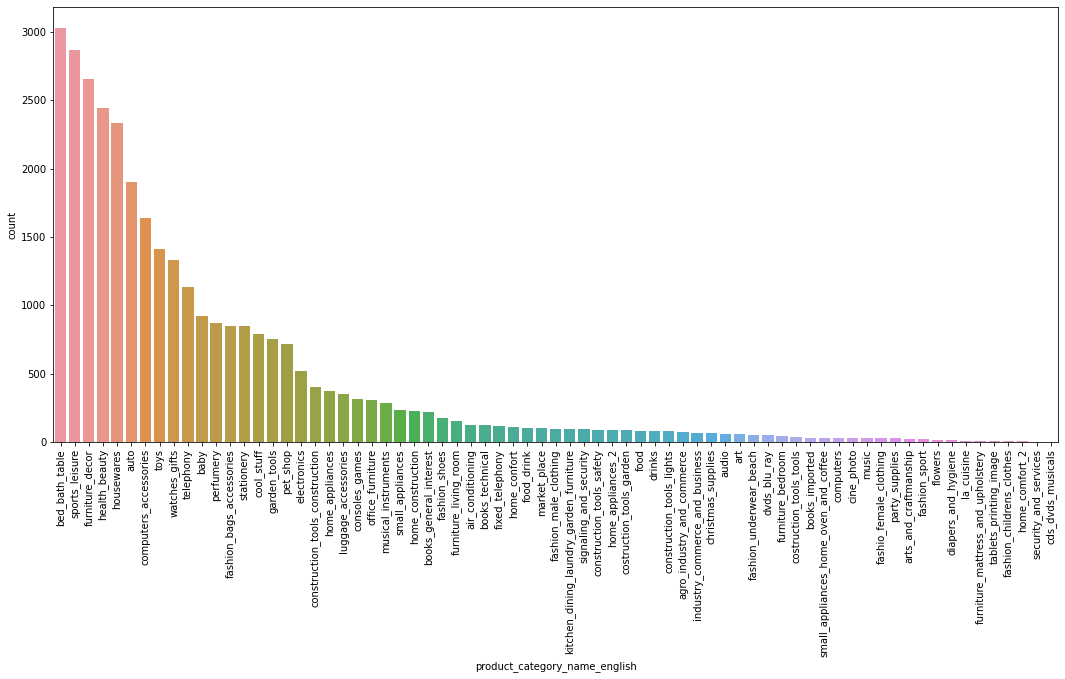

In [14]:
# Count plot des produits dans le nouveau dataset

plt.figure(figsize=(18, 8))
sns.countplot(data=products, 
              x="product_category_name_english",
              order = products['product_category_name_english'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

Nous allons maintenant classer la liste des produits en deux catégories. 
   1. Categorie 1 : Les produits "consommables" que les clients se seraient suceptible de revenir sur le site pour s'en procurer, tel que les produits de beauté, les livres, etc.
   2. Categorie 2 : Les produits tel que les meubles de salon, électroménagers etc.

In [15]:
categ_name_replace = {"product_category_name_english": 
                                                      {"bed_bath_table": "C2", 
                                                       "housewares": "C2", 
                                                       "home_appliances": "C2",
                                                       "construction_tools_construction": "C2",
                                                       "home_construction": "C2",
                                                       "air_conditioning": "C2",
                                                       "home_confort": "C2",
                                                       "kitchen_dining_laundry_garden_furniture": "C2",
                                                       "home_appliances_2": "C2",
                                                       "furniture_bedroom": "C2",
                                                       "furniture_living_room": "C2"
                                                      }
                     }

products = products.replace(categ_name_replace)

products['product_category_name_english'] = np.where((products['product_category_name_english']\
                                                                      .str.contains("C2")==True),
                                                         'C2','C1')

products = products.rename(columns={'product_category_name_english':'prod_categ'})


# new_products.head()
# show_isNull_NUnique_shape(new_products)

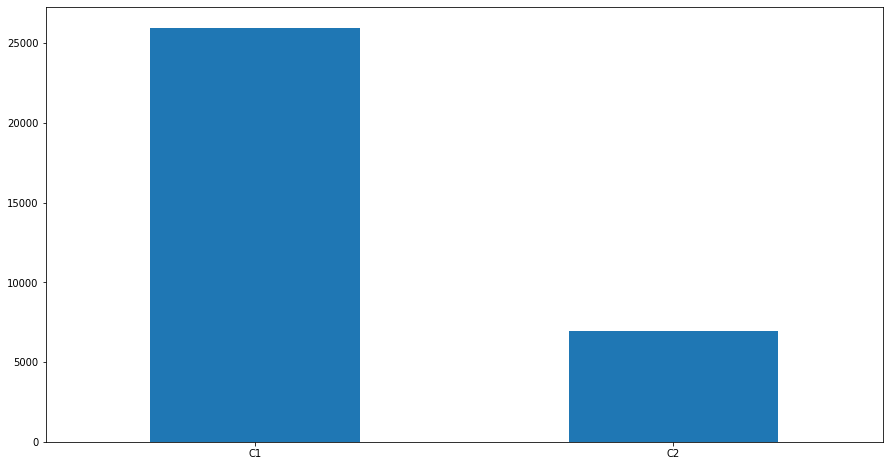

In [16]:
products['prod_categ'].value_counts().plot.bar(figsize=(15,8), rot=0)
plt.show()

## <font color="blue" id=section_1_2> 1.2 `Orders`. </font>

In [17]:
orders = pd.read_csv("archive/olist_orders_dataset.csv")
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [18]:
# On commence par supprimer les variables qui ne nous serons pas utiles par la suite
orders.drop(['order_approved_at',
             'order_estimated_delivery_date',
             'order_delivered_carrier_date'], axis=1, inplace=True)

show_isNull_NUnique_shape(orders) 

Le dataframe contient 5 colonnes et 99441 lignes.

NUnique
------
order_id========================================== 99441
customer_id======================================= 99441
order_status====================================== 8
order_purchase_timestamp========================== 98875
order_delivered_customer_date===================== 95664

IsNull
------
order_id========================================== 0
customer_id======================================= 0
order_status====================================== 0
order_purchase_timestamp========================== 0
order_delivered_customer_date===================== 2965


Ce dataset nous permettra de relier l'identifiant de la commande avec celui du client.

In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_delivered_customer_date  96476 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


In [20]:
# Changement du type pour les variables contenant les dates

orders[["order_purchase_timestamp", 
        "order_delivered_customer_date"]] = \
orders[["order_purchase_timestamp", 
        "order_delivered_customer_date"]].apply(pd.to_datetime)

### Statistique univariée

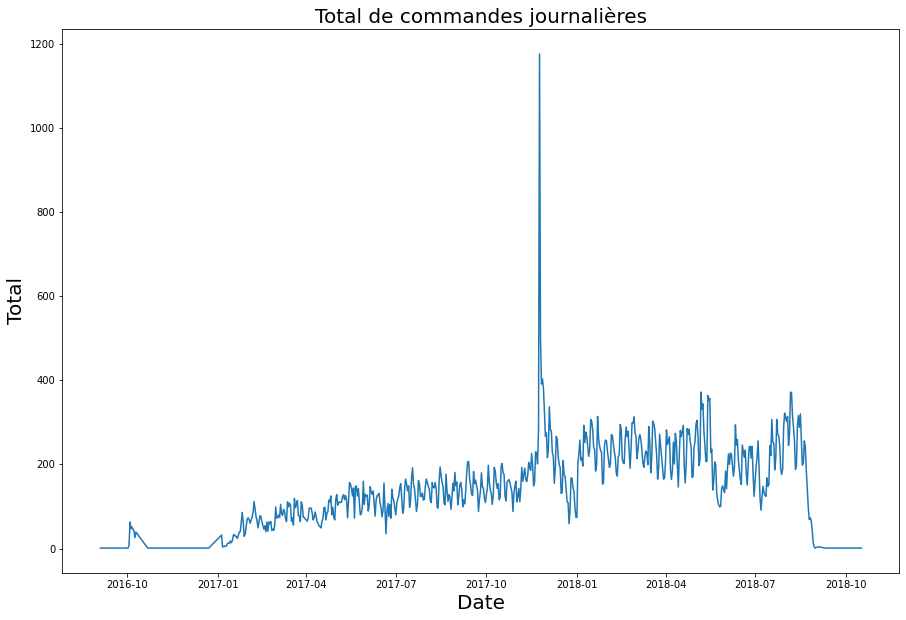

In [21]:
all_orders_purchase_date = orders.groupby(orders["order_purchase_timestamp"].dt.date)\
                                                ['order_purchase_timestamp'].count()

plt.figure(figsize=(15, 10))
all_orders_purchase_date.plot()
plt.ylabel('Total', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Total de commandes journalières', fontsize=20)
plt.show()

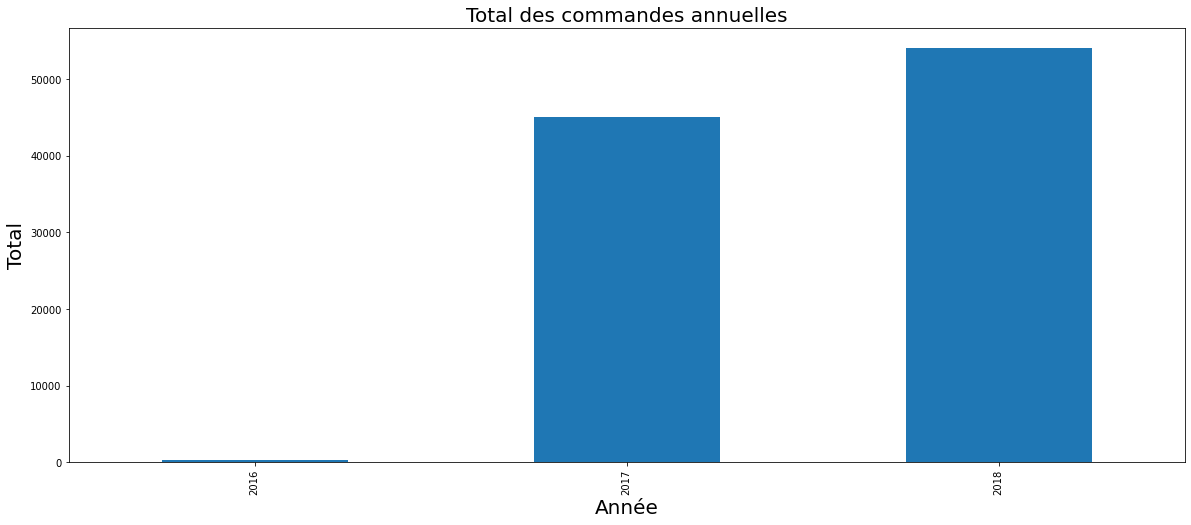

In [22]:
all_orders_purchase_year = orders.groupby(orders["order_purchase_timestamp"].dt.year)\
                                                ['order_purchase_timestamp'].count()

plt.figure(figsize=(20, 8))
all_orders_purchase_year.plot(kind='bar')
plt.ylabel('Total', fontsize=20)
plt.xlabel('Année', fontsize=20)
plt.title('Total des commandes annuelles', fontsize=20)
plt.show()

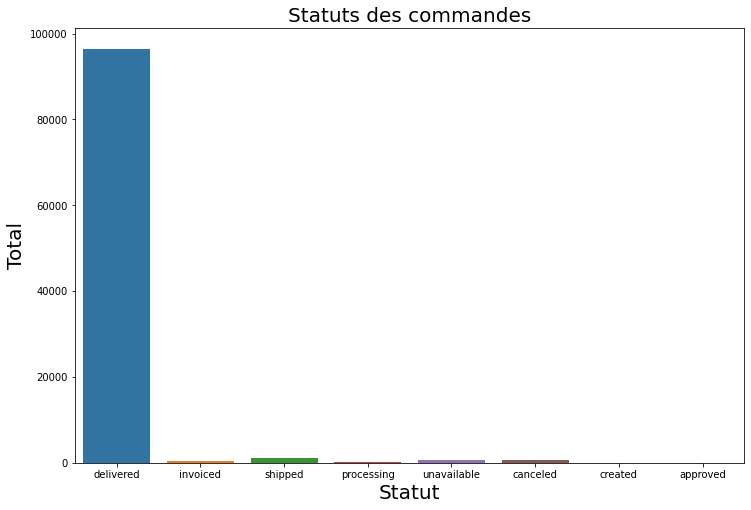

In [23]:
fig = plt.figure(figsize=(12, 8))
sns.countplot(data=orders, x="order_status")
plt.ylabel('Total', fontsize=20)
plt.xlabel('Statut', fontsize=20)
plt.title('Statuts des commandes', fontsize=20)
plt.show()

Nous allons restreindre notre analyse de segmentation en ne considérant que les clients qui ont été livrés.

In [24]:
orders = orders[orders['order_status']=='delivered']

# On supprime alors la variable "order_status"
orders.drop(['order_status'], axis=1, inplace=True)

## <font color="blue"> 1.2.1 `Order Reviews`. </font>

In [25]:
order_reviews = pd.read_csv("archive/olist_order_reviews_dataset.csv")
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [26]:
# Supprimon les colonnes qui ne nous seront pas utiles par la suite

order_reviews.drop(['review_id',
                    'review_comment_title',
                    'review_comment_message',
                    'review_creation_date',
                    'review_answer_timestamp'], axis=1, inplace=True)

show_isNull_NUnique_shape(order_reviews)  

Le dataframe contient 2 colonnes et 99224 lignes.

NUnique
------
order_id========================================== 98673
review_score====================================== 5

IsNull
------
order_id========================================== 0
review_score====================================== 0


### Statistique univariée

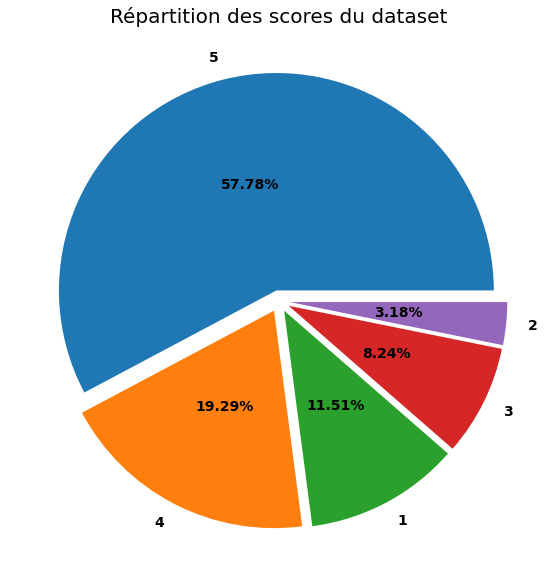

In [27]:
to_pie = order_reviews.review_score.value_counts()
colors = sns.color_palette('pastel')# [0:5]
n_expl = len(to_pie.index)
fig = plt.figure(figsize=(15,10))
plt.pie(to_pie, 
         labels      = to_pie.index,
         textprops   = {'fontsize': 14, 'weight': 'bold',},
         autopct     = "%.2f%%",
         explode     = [0.05]*n_expl,
         pctdistance = 0.5)
plt.title("Répartition des scores du dataset",fontsize=20)
plt.show()

On fusionne maintenant les datasets **`orders`** et **`order_reviews`** en réalisant une jointure sur la variable `order_id`. On associe alors chaque commande avec le *score*.

In [28]:
orders = pd.merge(orders, order_reviews,
                       how="left",
                       on="order_id")

# order_items_products.head()
show_isNull_NUnique_shape(orders)

Le dataframe contient 5 colonnes et 97007 lignes.

NUnique
------
order_id========================================== 96478
customer_id======================================= 96478
order_purchase_timestamp========================== 95956
order_delivered_customer_date===================== 95658
review_score====================================== 5

IsNull
------
order_id========================================== 0
customer_id======================================= 0
order_purchase_timestamp========================== 0
order_delivered_customer_date===================== 8
review_score====================================== 646


## <font color="blue"> 1.2.2 `Order Items`. </font>

In [29]:
order_items = pd.read_csv("archive/olist_order_items_dataset.csv")
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [30]:
# Suppression des colonnes inutiles

order_items.drop(['order_item_id',
                  'seller_id', 
                  'shipping_limit_date'], axis=1, inplace=True)

show_isNull_NUnique_shape(order_items)  

Le dataframe contient 4 colonnes et 112650 lignes.

NUnique
------
order_id========================================== 98666
product_id======================================== 32951
price============================================= 5968
freight_value===================================== 6999

IsNull
------
order_id========================================== 0
product_id======================================== 0
price============================================= 0
freight_value===================================== 0


On fusionne maintenant ce dataset avec **`orders`** pour avoir le dataset élargi des commandes passées sur le site.

In [31]:
orders = pd.merge(orders, order_items,
                       how="left",
                       on="order_id")

# all_orders.head()
show_isNull_NUnique_shape(orders)

Le dataframe contient 8 colonnes et 110840 lignes.

NUnique
------
order_id========================================== 96478
customer_id======================================= 96478
order_purchase_timestamp========================== 95956
order_delivered_customer_date===================== 95658
review_score====================================== 5
product_id======================================== 32216
price============================================= 5859
freight_value===================================== 6924

IsNull
------
order_id========================================== 0
customer_id======================================= 0
order_purchase_timestamp========================== 0
order_delivered_customer_date===================== 8
review_score====================================== 827
product_id======================================== 0
price============================================= 0
freight_value===================================== 0


## <font color="blue" id=section_1_3 > 1.3 `Customers`. </font>

In [32]:
customers = pd.read_csv("archive/olist_customers_dataset.csv")
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [33]:
# Suppression des colonnes inutiles

customers.drop(['customer_zip_code_prefix',
               'customer_city'], axis=1, inplace=True)

show_isNull_NUnique_shape(customers)

Le dataframe contient 3 colonnes et 99441 lignes.

NUnique
------
customer_id======================================= 99441
customer_unique_id================================ 96096
customer_state==================================== 27

IsNull
------
customer_id======================================= 0
customer_unique_id================================ 0
customer_state==================================== 0


Pour ce dataset, il faut comprendre la distinction entre les variables `customer_id` & `customer_unique_id`. On voit que pour une valeur de `customer_unique_id` plusieurs valeurs de `customer_id` peuvent exister. Ce dernier représente donc le nombre de total de visites du clients sur le site.

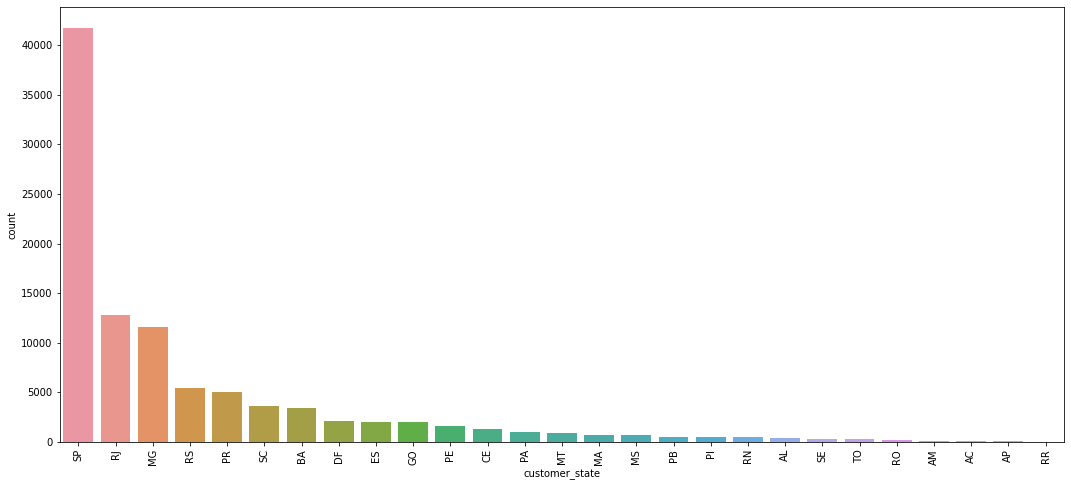

In [34]:
# Count plot des villes les plus représentées dans le dataset

plt.figure(figsize=(18, 8))
sns.countplot(data=customers, 
              x="customer_state",
              order = customers['customer_state'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

## <font color="blue" id=section_1_4 > 1.4 Dataset étendu. </font>

On va maintenant fusionner les trois datasets **`products`**, **`orders`** et **`customers`**, pour réaliser le *feature engineering* qui nous permettra, dans la section suivante, de créer les variables pertinentes pour la segmentation des clients.

On fusionne dans un premier temps, **`orders`** et **`customers`** avec une jointure sur la variable `customer_id`.

In [35]:
data = pd.merge(orders, customers,
                how="left",
                on="customer_id")

Enfin, on fusionne ce nouveau dataset **`data`** avec **`products`** avec une jointure sur la variable `product_id`.

In [36]:
data = pd.merge(data, products,
                how="left",
                on="product_id")

In [37]:
data.head()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,review_score,product_id,price,freight_value,customer_unique_id,customer_state,prod_categ
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,4.0,87285b34884572647811a353c7ac498a,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,SP,C2
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-08-07 15:27:45,4.0,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,af07308b275d755c9edb36a90c618231,BA,C1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-17 18:06:29,5.0,aa4383b373c6aca5d8797843e5594415,159.90,19.22,3a653a41f6f9fc3d2a113cf8398680e8,GO,C1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-12-02 00:28:42,5.0,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,7c142cf63193a1473d2e66489a9ae977,RN,C1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-16 18:17:02,5.0,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,72632f0f9dd73dfee390c9b22eb56dd6,SP,C1


## <font color="blue" id=section_1_5 > 1.5 Imputation. </font>

In [38]:
show_isNull_NUnique_shape(data)

Le dataframe contient 11 colonnes et 110840 lignes.

NUnique
------
order_id========================================== 96478
customer_id======================================= 96478
order_purchase_timestamp========================== 95956
order_delivered_customer_date===================== 95658
review_score====================================== 5
product_id======================================== 32216
price============================================= 5859
freight_value===================================== 6924
customer_unique_id================================ 93358
customer_state==================================== 27
prod_categ======================================== 2

IsNull
------
order_id========================================== 0
customer_id======================================= 0
order_purchase_timestamp========================== 0
order_delivered_customer_date===================== 8
review_score====================================== 827
product_id==========================

Nous n'allons simplement pas tenir compte des données où les dates de livraisons sont absentes. Nous allons donc les supprimer pour ne pas risquer d'obtenir des dates de livraisons antérieures à la date de commande.

In [39]:
data = data[~data[['order_delivered_customer_date']].isnull().any(axis=1)]
show_isNull_NUnique_shape(data)

Le dataframe contient 11 colonnes et 110832 lignes.

NUnique
------
order_id========================================== 96470
customer_id======================================= 96470
order_purchase_timestamp========================== 95948
order_delivered_customer_date===================== 95658
review_score====================================== 5
product_id======================================== 32214
price============================================= 5859
freight_value===================================== 6924
customer_unique_id================================ 93350
customer_state==================================== 27
prod_categ======================================== 2

IsNull
------
order_id========================================== 0
customer_id======================================= 0
order_purchase_timestamp========================== 0
order_delivered_customer_date===================== 0
review_score====================================== 827
product_id==========================

Il reste toujours 827 observations nulles concernant le *score*. Nous allons imputer ces observations en utilisant la moyenne dans le dataset.

In [40]:
# Imputation avec most_frequent
missing_features = data.isnull().sum()
missing_features = list(missing_features[missing_features.values > 0].index)
for f in missing_features:
    data[f] = data[f].fillna(data[f].mean())

In [41]:
show_isNull_NUnique_shape(data)

Le dataframe contient 11 colonnes et 110832 lignes.

NUnique
------
order_id========================================== 96470
customer_id======================================= 96470
order_purchase_timestamp========================== 95948
order_delivered_customer_date===================== 95658
review_score====================================== 6
product_id======================================== 32214
price============================================= 5859
freight_value===================================== 6924
customer_unique_id================================ 93350
customer_state==================================== 27
prod_categ======================================== 2

IsNull
------
order_id========================================== 0
customer_id======================================= 0
order_purchase_timestamp========================== 0
order_delivered_customer_date===================== 0
review_score====================================== 0
product_id============================

# <font color="blue" id=section_2> 2. Feature engineering pour l'analyse RFM. </font>

# <font color="blue" id=section_2_1> 2.1 OHE pour la variable `prod_categ`. </font>

In [42]:
data_dumm = pd.get_dummies(data, columns=['prod_categ'])
data_dumm = data_dumm.rename(columns={'prod_categ_C1':'C1',
                                      'prod_categ_C2': 'C2'})

In [43]:
# On crée une nouvelle ariable pour avoir la date de reference
cur_time = data_dumm.order_purchase_timestamp.max() 

# <font color="blue" id=section_2_2> 2.2 Temps de livraison des commandes. </font>

In [44]:
data_dumm["delay_delivery"] = (data_dumm.order_delivered_customer_date
                               - data_dumm.order_purchase_timestamp).dt.round('1d').dt.days

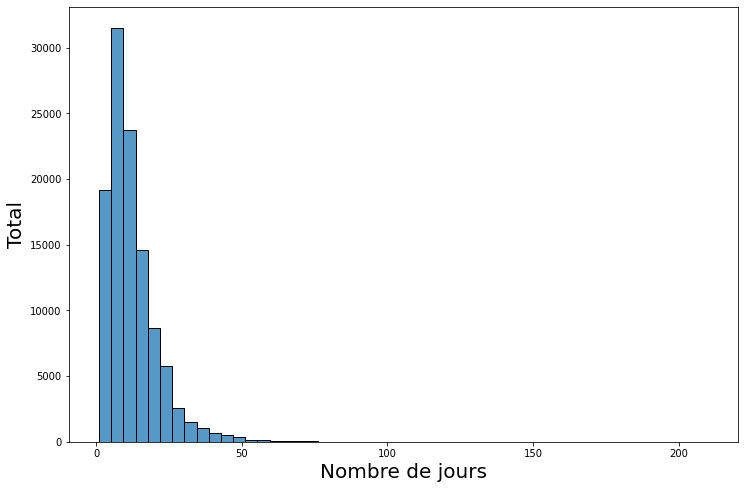

In [45]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data=data_dumm, 
             x="delay_delivery",
             bins=50)
# plt.title("Temps de livraison en jours des produits", fontsize=20)
plt.xlabel("Nombre de jours", fontsize=20)
plt.ylabel("Total", fontsize=20)
plt.show()

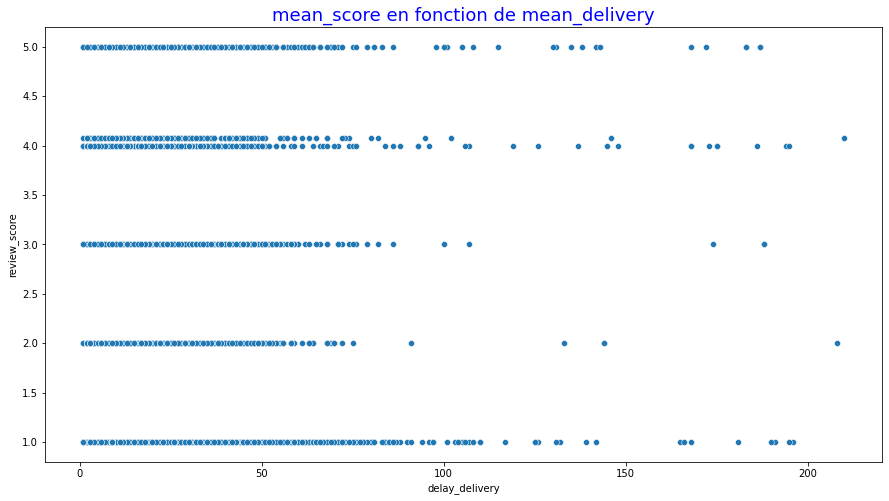

In [46]:
fig = plt.figure(figsize=(15,8))

sns.scatterplot(data=data_dumm, 
                y='review_score',
                x='delay_delivery')
plt.title("mean_score en fonction de mean_delivery", fontsize=18, color="b")
plt.show()

# <font color="blue" id=section_2_3> 2.3 Aggrégations sur les variables. </font>

On défini ici de nouvelles variables qui seront obtenues via aggrégations de celles existantes. Ces variables seront utiles pour l'analyse RFM que nous emploierons pour la segmentation.

In [47]:
df = data_dumm.groupby("customer_unique_id").\
                    agg(nb_visits=("customer_id", "nunique"),
                        count_products=("product_id","count"),
                        total_price=("price", "sum"),
                        mean_price=("price","mean"),
                        total_freight=("freight_value","sum"),
                        mean_score=("review_score", "mean"),
                        mean_delivery_delay=("delay_delivery", "mean"),
                        total_C1=("C1", "sum"),
                        total_C2=("C2", "sum"),
                        first_purchase=('order_purchase_timestamp', 'min'), 
                        last_purchase=('order_purchase_timestamp', 'max'),
                        favorite_city=("customer_state", lambda x:x.value_counts().index[0])
                         )

df = df.reset_index()

# show_isNull_NUnique_shape(df)

### Recency 

On défini la *Recency* comme la date du dernier achat, la dernière visite ou de la dernière commande d’un client.

In [48]:
# On utilise la fonction ci-dessous pour mesurer sur une échelle mensuelle.

def month_diff(cur_time, datetime_val): 
    return 12 * (cur_time.year - datetime_val.year) + (cur_time.month - datetime_val.month)# recency month

In [49]:
df['cust_recency'] = df.last_purchase.apply(lambda x: month_diff(cur_time, x))

<AxesSubplot:>

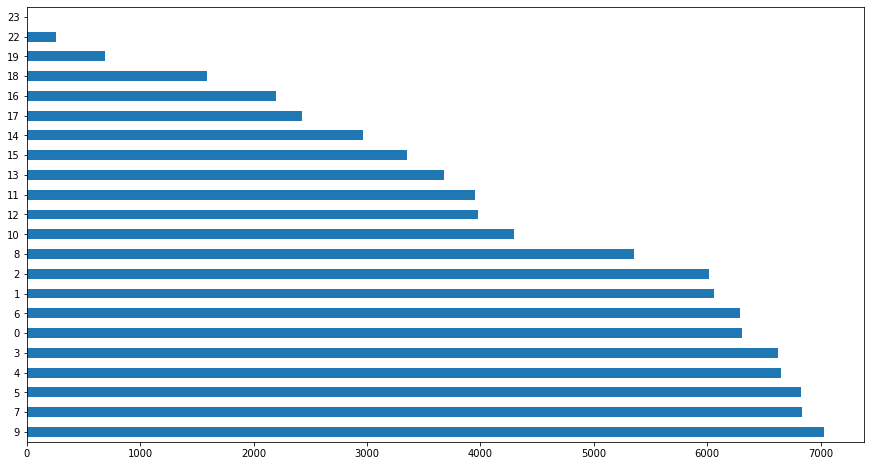

In [50]:
df['cust_recency'].value_counts().plot.barh(figsize=(15,8))

### Frequency

On utilise la *Frequency* pour mesurer la fidélité comportementale du client. Elle est défini comme le nombre de fois où le client est venu sur le site sur une période donnée.

In [51]:
df['cust_frequency'] = df.first_purchase.apply(lambda x: month_diff(cur_time, x))
df['cust_frequency'] = np.round(df['cust_frequency'].div(df['nb_visits']))

<AxesSubplot:>

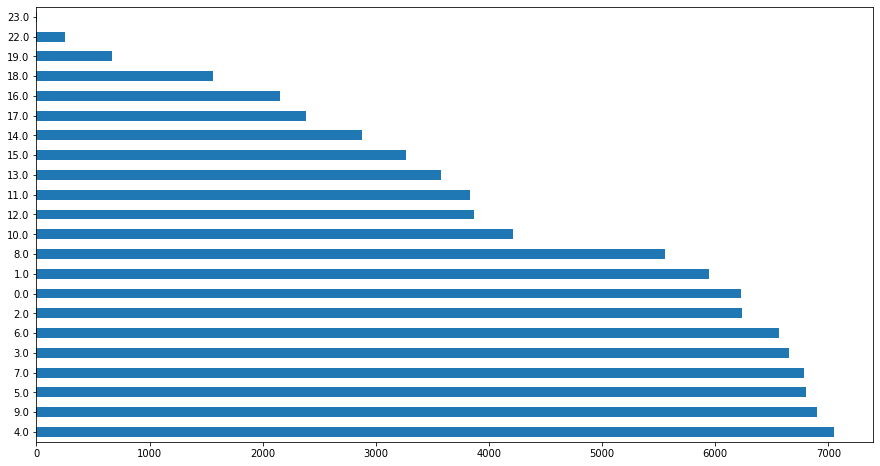

In [52]:
df['cust_frequency'].value_counts().plot.barh(figsize=(15,8))

### Monetary
C’est le montant du panier moyen d'un client sur une période donnée.

In [53]:
df['total_spend']   = (df.total_price + df.total_freight)
df['cust_monetary'] = df['total_spend'].div(df['count_products'])

### Ratio C1_C2

Enfin, en plus des variables, on défini aussi une variable ratio qui nous permettra de savoir quelle type d'achat un client se rend sur le site.

In [54]:
df['ratio_C1'] = df['total_C1'].div(df['count_products'])
df['ratio_C2'] = df['total_C2'].div(df['count_products'])

# df.drop(['total_Conso',
#          'total_NonConso'], axis=1, inplace=True)

In [55]:
df.describe()

,nb_visits,count_products,total_price,mean_price,total_freight,mean_score,mean_delivery_delay,total_C1,total_C2,cust_recency,cust_frequency,total_spend,cust_monetary,ratio_C1,ratio_C2
count,93350.000000,93350.000000,93350.000000,93350.000000,93350.000000,93350.000000,93350.00000,93350.000000,93350.000000,93350.000000,93350.000000,93350.000000,93350.000000,93350.000000,93350.000000
mean,1.033423,1.187274,142.245178,125.829183,23.671122,4.152930,12.52509,0.950927,0.236347,7.365185,7.301575,165.916300,146.013868,0.811561,0.188439
std,0.209106,0.650841,216.939307,190.544702,23.084932,1.276148,9.55154,0.711063,0.575475,5.027389,4.998368,227.795514,197.739080,0.388330,0.388330
min,1.000000,1.000000,0.850000,0.850000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,9.590000,9.341429,0.000000,0.000000
25%,1.000000,1.000000,47.800000,42.900000,14.080000,4.000000,7.00000,1.000000,0.000000,3.000000,3.000000,63.100000,57.750000,1.000000,0.000000
50%,1.000000,1.000000,89.900000,79.000000,17.600000,5.000000,10.00000,1.000000,0.000000,7.000000,7.000000,107.885000,96.485000,1.000000,0.000000
75%,1.000000,1.000000,155.000000,139.900000,25.580000,5.000000,16.00000,1.000000,0.000000,11.000000,11.000000,183.120000,162.767500,1.000000,0.000000
max,15.000000,24.000000,13440.000000,6735.000000,1794.960000,5.000000,210.00000,24.000000,24.000000,23.000000,23.000000,13664.080000,6929.310000,1.000000,1.000000


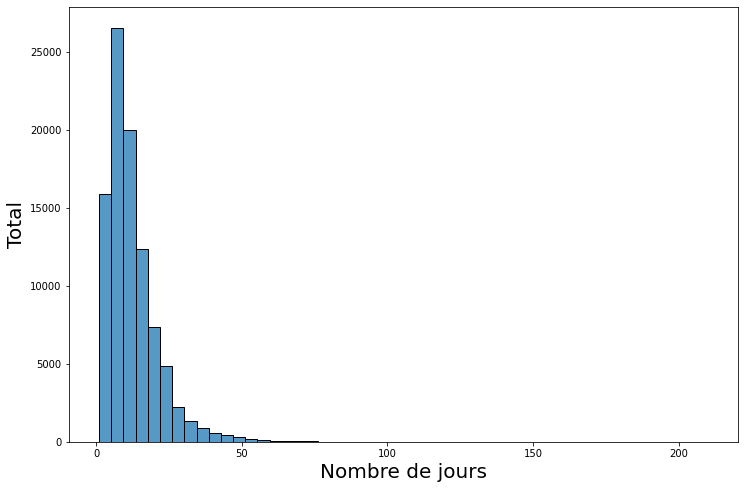

In [56]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data=df, 
             x="mean_delivery_delay",
             bins=50)
# plt.title("Temps de livraison en jours des produits", fontsize=20)
plt.xlabel("Nombre de jours", fontsize=20)
plt.ylabel("Total", fontsize=20)
plt.show()

# <font color="blue" id=section_2_4> 2.4 Statistiques bivariées. </font>

### Saisonnalité des ventes

In [57]:
# On crée une nouvelle variable pour avoir le mois d'achat
data["purchase_month"] = data['order_purchase_timestamp'].dt.month

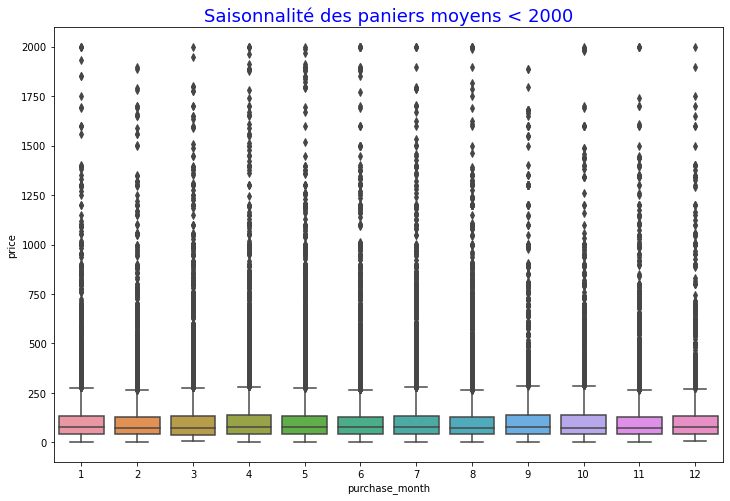

In [58]:
fig = plt.figure(figsize=(12,8))
sns.boxplot(data=data[data.price <2000], x="purchase_month", y="price")
plt.title("Saisonnalité des paniers moyens < 2000", fontsize=18, color="b")
plt.show()

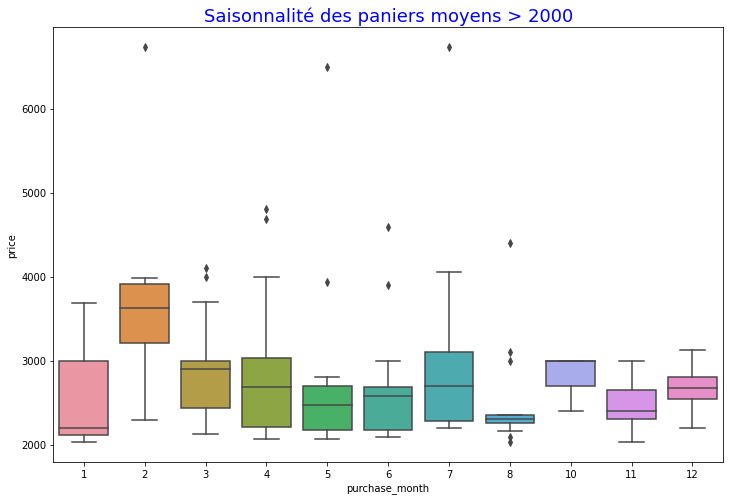

In [59]:
fig = plt.figure(figsize=(12,8))
sns.boxplot(data=data[data.price >2000], x="purchase_month", y="price")
plt.title("Saisonnalité des paniers moyens > 2000", fontsize=18, color="b")
plt.show()

### Clients insatisfaits

Sur le graphique ci-dessous, on peut voir qu'il y a une minorité de clients qui sont réguliers mais très insatisfaits.

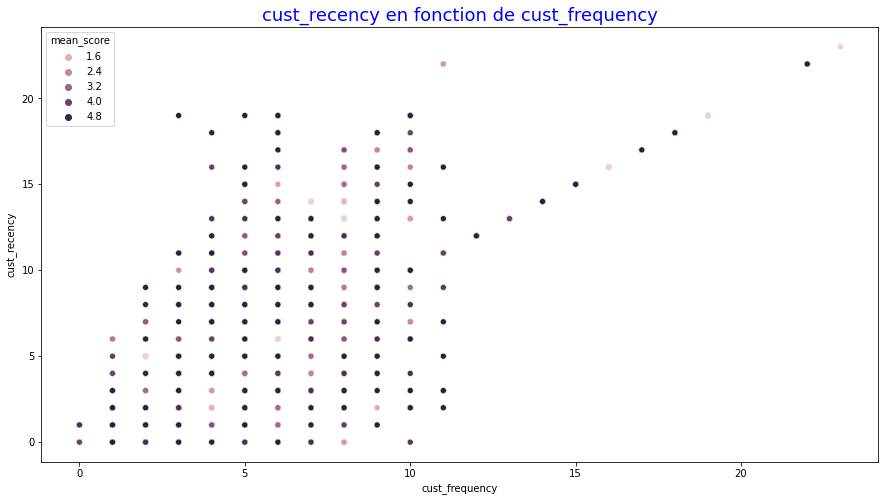

In [60]:
fig = plt.figure(figsize=(15,8))

sns.scatterplot(data=df, #[df['mean_score']<=1], 
                x='cust_frequency',
                y='cust_recency',
                hue='mean_score')
plt.title("cust_recency en fonction de cust_frequency", fontsize=18, color="b")
plt.show()

D'autre part, l'insatisfaction des clients peut être expliqué par un retard de livraison. L'histogramme ci-dessous, est obtenu pour les temps de livraison supérieurs à 30 jours.

(611, 19)


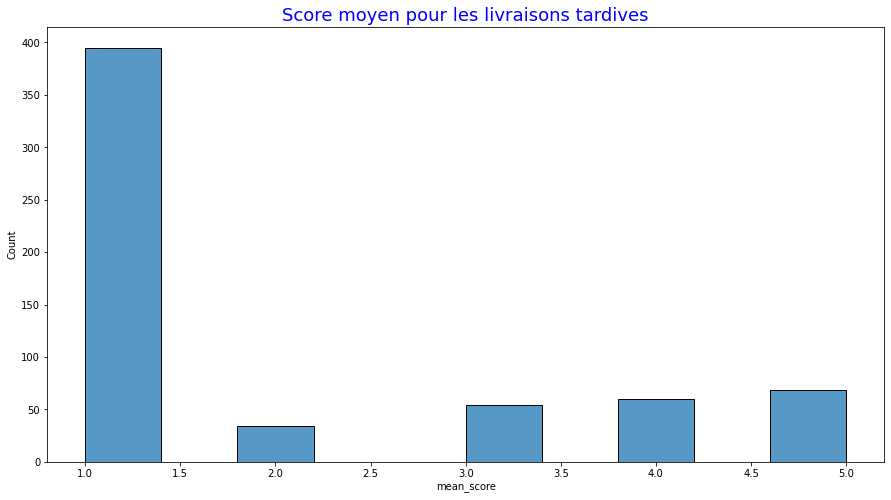

In [61]:
toto = df[(df['mean_delivery_delay']>50)]
print(toto.shape)

plt.figure(figsize=(15,8))
sns.histplot(data=toto, 
             x="mean_score", 
             bins=10)
plt.title("Score moyen pour les livraisons tardives", fontsize=18, color="b")
plt.show()

Dans ce notebook, nous avons fusionné et nettoyé les bases de données clients originaux pour obtenir un jeu de donnée étendu. Ensuite, de nouvelles variables ont été définies en utilisant la stratégie marketing RFM dans le but réaliser une segmentation des clients sur le dataset final. Ce travail sera l'objet du notebook suivant.

In [62]:
# Suppression des variables qui ne nous serons plus utiles par la suite.

df.drop(['mean_price',
                 'last_purchase',
                 'first_purchase',
                 'total_price',
                 'total_freight',
                 'total_spend',
                 'count_products',
                 'nb_visits',
                 'total_C1',
                 'total_C2',
                 'ratio_C2',
], axis=1, inplace=True)

In [63]:
df.to_csv('cleaned_dataset.csv')